**GaussianHMM on the Ionosphere dataset**

In [ ]:
!pip install hmmlearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import warnings

warnings.filterwarnings("ignore")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
data = pd.read_csv(url, header=None)
X = data.iloc[:, :-1].values
y_raw = data.iloc[:, -1].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

In [ ]:
split_ratios = [0.2, 0.3, 0.4]
n_components_range = range(2, 9)

results = []
best_overall_accuracy = 0.0
best_config = {}
best_model_details = {}

print(" Starting Full Search (Splits and Parameters) ")

for split in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_train_class0 = X_train[y_train == 0]
    X_train_class1 = X_train[y_train == 1]

    if len(X_train_class0) == 0 or len(X_train_class1) == 0:
        continue

    for n in n_components_range:
        hmm_class0 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
        hmm_class1 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
        hmm_class0.fit(X_train_class0)
        hmm_class1.fit(X_train_class1)

        y_pred, y_scores = [], []
        for sample in X_test:
            sample_reshaped = sample.reshape(1, -1)
            score0, score1 = hmm_class0.score(sample_reshaped), hmm_class1.score(sample_reshaped)
            y_pred.append(1 if score1 > score0 else 0)
            y_scores.append(score1 - score0)

        accuracy = accuracy_score(y_test, y_pred)
        results.append({'split': int((1 - split) * 100), 'n_components': n, 'accuracy': accuracy})

        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_config = {'split': f"{int((1-split)*100)}/{int(split*100)}", 'n_components': n}
            best_model_details = {'y_test': y_test, 'y_pred': y_pred, 'y_scores': y_scores,
                                'X_train_class0': X_train_class0, 'X_train_class1': X_train_class1}

print(" Search Complete ")

 Starting Full Search (Splits and Parameters) 


 Search Complete 


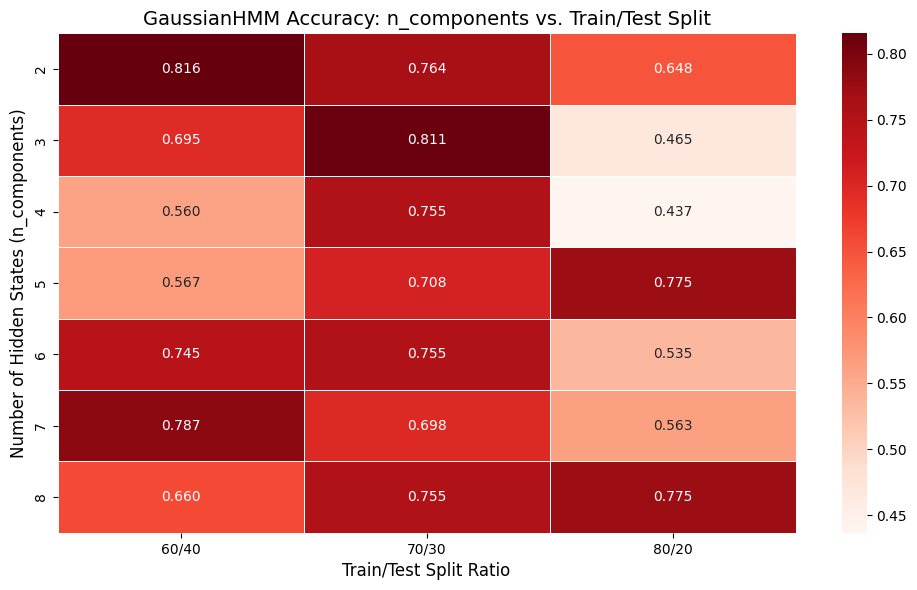

In [ ]:
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot(index='n_components', columns='split', values='accuracy')
pivot_table.columns = [f"{col}/{(100-col)}" for col in pivot_table.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="Reds", linewidths=.5)
plt.title('GaussianHMM Accuracy: n_components vs. Train/Test Split', fontsize=14)
plt.xlabel('Train/Test Split Ratio', fontsize=12)
plt.ylabel('Number of Hidden States (n_components)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Generating visualizations for the BEST model configuration:")
print(f"Split: {best_config['split']}, n_components: {best_config['n_components']}, Accuracy: {best_overall_accuracy:.3f}")


Generating visualizations for the BEST model configuration:
Split: 60/40, n_components: 2, Accuracy: 0.816


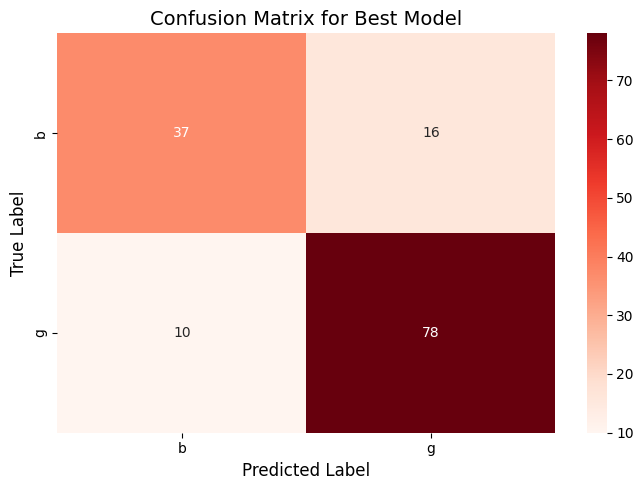

In [ ]:
cm = confusion_matrix(best_model_details['y_test'], best_model_details['y_pred'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best Model', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

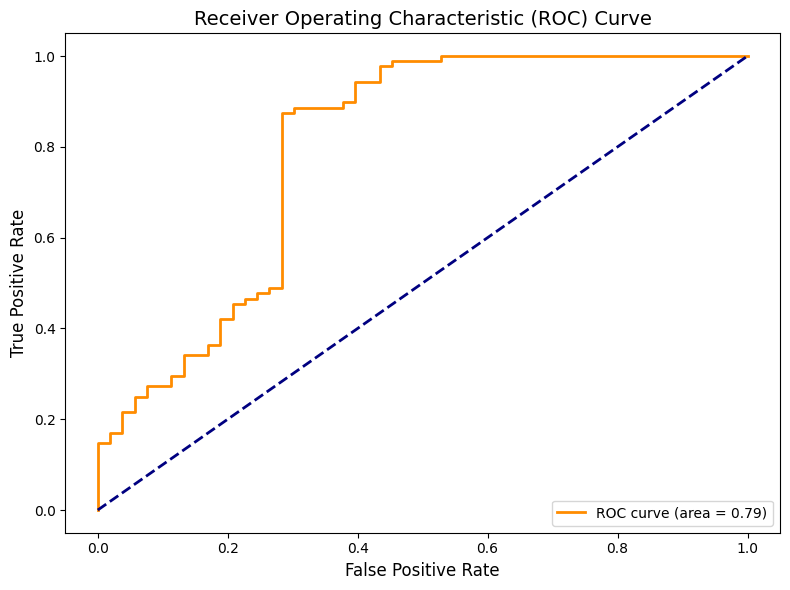

In [ ]:
fpr, tpr, _ = roc_curve(best_model_details['y_test'], best_model_details['y_scores'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Retraining best model to capture convergence history...


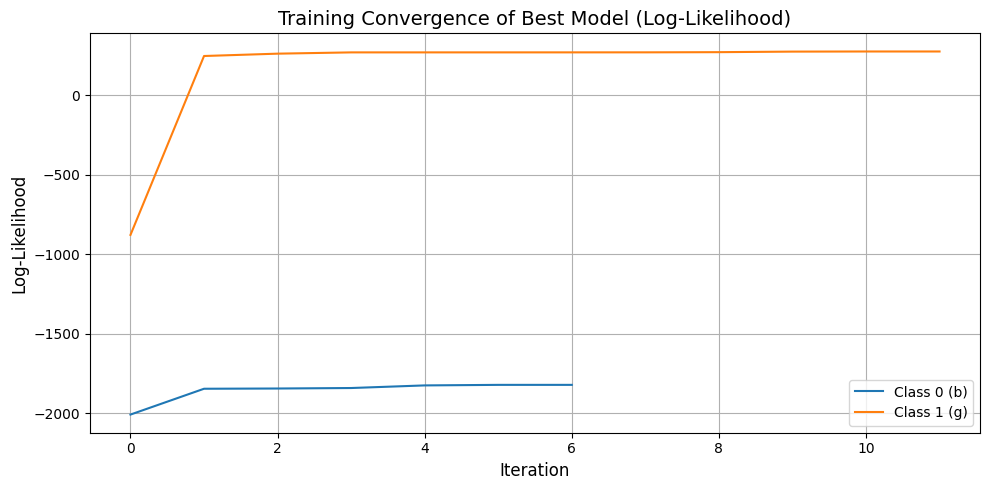

In [ ]:
print("\nRetraining best model to capture convergence history")
best_n = best_config['n_components']
hmm0 = hmm.GaussianHMM(n_components=best_n, covariance_type="diag", n_iter=100, random_state=42)
hmm1 = hmm.GaussianHMM(n_components=best_n, covariance_type="diag", n_iter=100, random_state=42)
hmm0.fit(best_model_details['X_train_class0'])
hmm1.fit(best_model_details['X_train_class1'])
log_likelihood_history0, log_likelihood_history1 = hmm0.monitor_.history, hmm1.monitor_.history

plt.figure(figsize=(10, 5))
plt.plot(log_likelihood_history0, label=f'Class 0 ({class_names[0]})')
plt.plot(log_likelihood_history1, label=f'Class 1 ({class_names[1]})')
plt.title('Training Convergence of Best Model (Log-Likelihood)', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**MultinomialHMM on the Ionosphere dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")



In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
data = pd.read_csv(url, header=None)
X_continuous = data.iloc[:, :-1].values # Keep the original continuous data
y_raw = data.iloc[:, -1].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

In [ ]:
print(" Discretizing Data for MultinomialHMM ")
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
X = discretizer.fit_transform(X_continuous).astype(int)

print("Original first sample (first 5 features):", X_continuous[0, :5])
print("Discretized first sample (first 5 features):", X[0, :5])


 Discretizing Data for MultinomialHMM 
Original first sample (first 5 features): [ 1.       0.       0.99539 -0.05889  0.85243]
Discretized first sample (first 5 features): [9 0 9 4 9]


In [ ]:
split_ratios = [0.2, 0.3, 0.4]
n_components_range = range(2, 9)

results_multi = []
best_overall_accuracy_multi = 0.0
best_config_multi = {}
best_model_details_multi = {}

print("\n Full Search for MultinomialHMM (Splits and Parameters) ")

for split in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_train_class0 = X_train[y_train == 0]
    X_train_class1 = X_train[y_train == 1]

    if len(X_train_class0) == 0 or len(X_train_class1) == 0:
        continue

    for n in n_components_range:
        hmm_class0 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)
        hmm_class1 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)

        hmm_class0.fit(X_train_class0)
        hmm_class1.fit(X_train_class1)

        y_pred, y_scores = [], []
        for sample in X_test:
            sample_reshaped = sample.reshape(1, -1)
            score0, score1 = hmm_class0.score(sample_reshaped), hmm_class1.score(sample_reshaped)
            y_pred.append(1 if score1 > score0 else 0)
            y_scores.append(score1 - score0)

        accuracy = accuracy_score(y_test, y_pred)
        results_multi.append({'split': int((1 - split) * 100), 'n_components': n, 'accuracy': accuracy})

        if accuracy > best_overall_accuracy_multi:
            best_overall_accuracy_multi = accuracy
            best_config_multi = {'split': f"{int((1-split)*100)}/{int(split*100)}", 'n_components': n}
            best_model_details_multi = {'y_test': y_test, 'y_pred': y_pred, 'y_scores': y_scores,
                                'X_train_class0': X_train_class0, 'X_train_class1': X_train_class1}

print(" Search Complete ")

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



 Full Search for MultinomialHMM (Splits and Parameters) 


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/iss

 Search Complete 


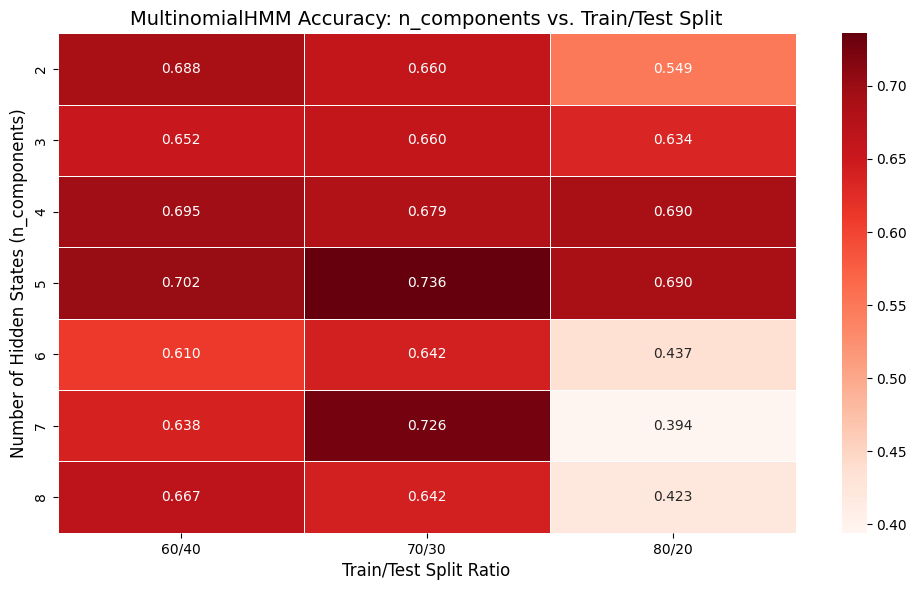

In [ ]:
results_df_multi = pd.DataFrame(results_multi)
pivot_table_multi = results_df_multi.pivot(index='n_components', columns='split', values='accuracy')
pivot_table_multi.columns = [f"{col}/{(100-col)}" for col in pivot_table_multi.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_multi, annot=True, fmt=".3f", cmap="Reds", linewidths=.5)
plt.title('MultinomialHMM Accuracy: n_components vs. Train/Test Split', fontsize=14)
plt.xlabel('Train/Test Split Ratio', fontsize=12)
plt.ylabel('Number of Hidden States (n_components)', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
print(f"Generating visualizations for the BEST MultinomialHMM model:")
print(f"Split: {best_config_multi['split']}, n_components: {best_config_multi['n_components']}, Accuracy: {best_overall_accuracy_multi:.3f}")


Generating visualizations for the BEST MultinomialHMM model:
Split: 70/30, n_components: 5, Accuracy: 0.736


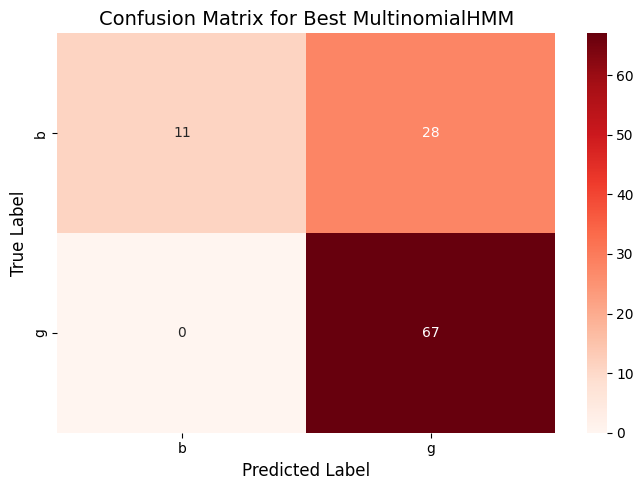

In [ ]:
cm = confusion_matrix(best_model_details_multi['y_test'], best_model_details_multi['y_pred'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best MultinomialHMM', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


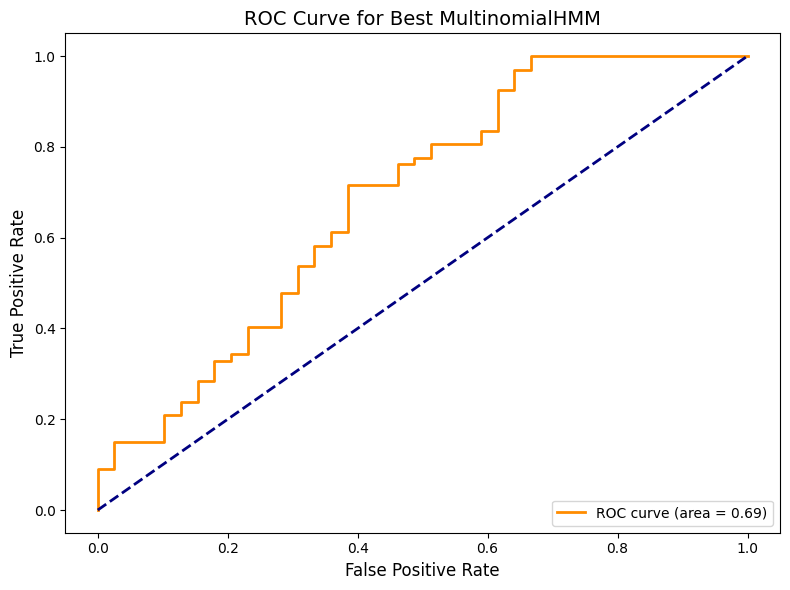

In [ ]:
fpr, tpr, _ = roc_curve(best_model_details_multi['y_test'], best_model_details_multi['y_scores'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Best MultinomialHMM', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Retraining best model to capture convergence history


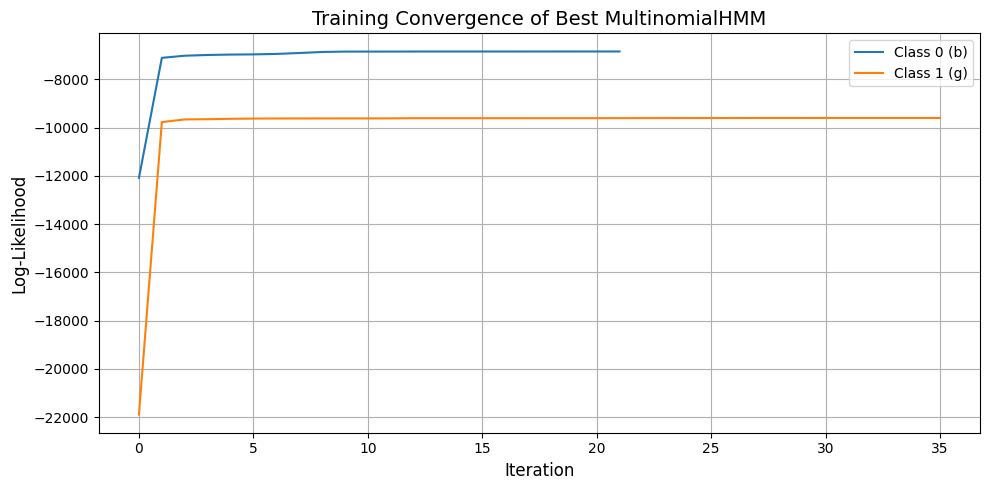

In [ ]:
print("\nRetraining best model to capture convergence history")
best_n = best_config_multi['n_components']
hmm0 = hmm.MultinomialHMM(n_components=best_n, n_iter=100, random_state=42)
hmm1 = hmm.MultinomialHMM(n_components=best_n, n_iter=100, random_state=42)
hmm0.fit(best_model_details_multi['X_train_class0'])
hmm1.fit(best_model_details_multi['X_train_class1'])
log_likelihood_history0, log_likelihood_history1 = hmm0.monitor_.history, hmm1.monitor_.history

plt.figure(figsize=(10, 5))
plt.plot(log_likelihood_history0, label=f'Class 0 ({class_names[0]})')
plt.plot(log_likelihood_history1, label=f'Class 1 ({class_names[1]})')
plt.title('Training Convergence of Best MultinomialHMM', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**GaussianHMM on the Wisconsin Breast Cancer dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(" Loading Wisconsin Breast Cancer Dataset ")
cancer_data = load_breast_cancer()
X_raw = cancer_data.data
y = cancer_data.target
class_names = cancer_data.target_names

print(f"Original data shape: {X_raw.shape}")
print(f"Target classes: {class_names}")

 Loading Wisconsin Breast Cancer Dataset 
Original data shape: (569, 30)
Target classes: ['malignant' 'benign']


In [ ]:
print("\n Scaling Features ")
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print("Data scaled successfully.")


 Scaling Features 
Data scaled successfully.


In [ ]:
split_ratios = [0.2, 0.3, 0.4]
n_components_range = range(2, 9)

results_bc = []
best_overall_accuracy_bc = 0.0
best_config_bc = {}
best_model_details_bc = {}

print("\n Starting Full Search for GaussianHMM (Splits and Parameters) ")

for split in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_train_class0 = X_train[y_train == 0]
    X_train_class1 = X_train[y_train == 1]

    if len(X_train_class0) == 0 or len(X_train_class1) == 0:
        continue

    for n in n_components_range:
        # Use GaussianHMM
        hmm_class0 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
        hmm_class1 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)

        hmm_class0.fit(X_train_class0)
        hmm_class1.fit(X_train_class1)

        y_pred, y_scores = [], []
        for sample in X_test:
            sample_reshaped = sample.reshape(1, -1)
            score0, score1 = hmm_class0.score(sample_reshaped), hmm_class1.score(sample_reshaped)
            y_pred.append(1 if score1 > score0 else 0)
            y_scores.append(score1 - score0)

        accuracy = accuracy_score(y_test, y_pred)
        results_bc.append({'split': int((1 - split) * 100), 'n_components': n, 'accuracy': accuracy})

        if accuracy > best_overall_accuracy_bc:
            best_overall_accuracy_bc = accuracy
            best_config_bc = {'split': f"{int((1-split)*100)}/{int(split*100)}", 'n_components': n}
            best_model_details_bc = {'y_test': y_test, 'y_pred': y_pred, 'y_scores': y_scores,
                                'X_train_class0': X_train_class0, 'X_train_class1': X_train_class1}

print(" Search Complete ")


 Starting Full Search for GaussianHMM (Splits and Parameters) 
 Search Complete 


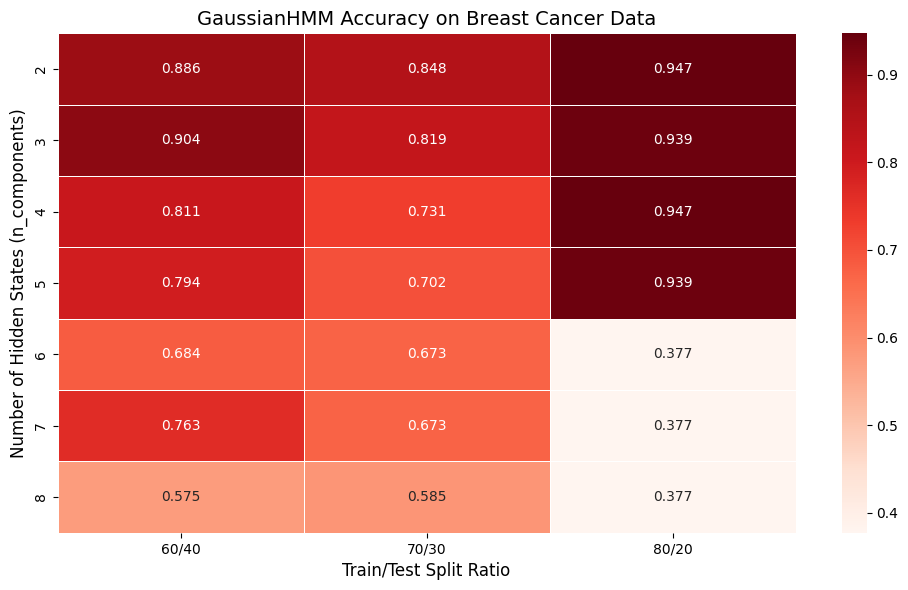

In [ ]:
results_df_bc = pd.DataFrame(results_bc)
pivot_table_bc = results_df_bc.pivot(index='n_components', columns='split', values='accuracy')
pivot_table_bc.columns = [f"{col}/{(100-col)}" for col in pivot_table_bc.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_bc, annot=True, fmt=".3f", cmap="Reds", linewidths=.5)
plt.title('GaussianHMM Accuracy on Breast Cancer Data', fontsize=14)
plt.xlabel('Train/Test Split Ratio', fontsize=12)
plt.ylabel('Number of Hidden States (n_components)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Generating visualizations for the BEST GaussianHMM model:")
print(f"Split: {best_config_bc['split']}, n_components: {best_config_bc['n_components']}, Accuracy: {best_overall_accuracy_bc:.3f}")


Generating visualizations for the BEST GaussianHMM model:
Split: 80/20, n_components: 2, Accuracy: 0.947


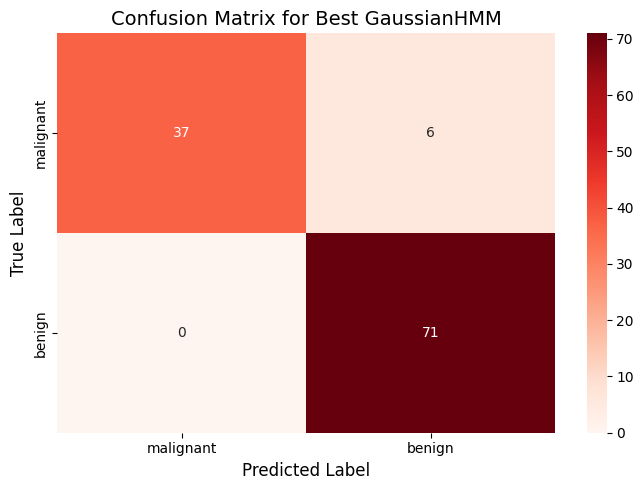

In [ ]:
cm = confusion_matrix(best_model_details_bc['y_test'], best_model_details_bc['y_pred'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best GaussianHMM', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

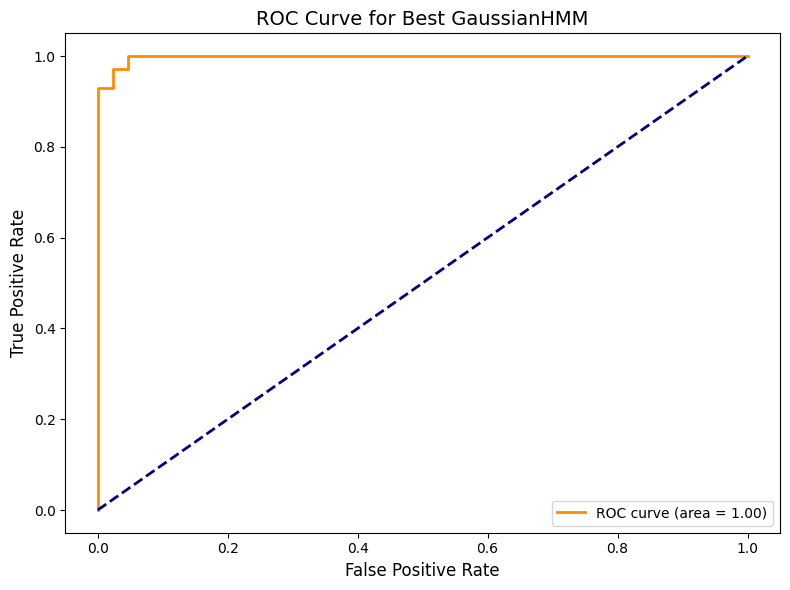

In [ ]:
fpr, tpr, _ = roc_curve(best_model_details_bc['y_test'], best_model_details_bc['y_scores'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Best GaussianHMM', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Retraining best model to capture convergence history...


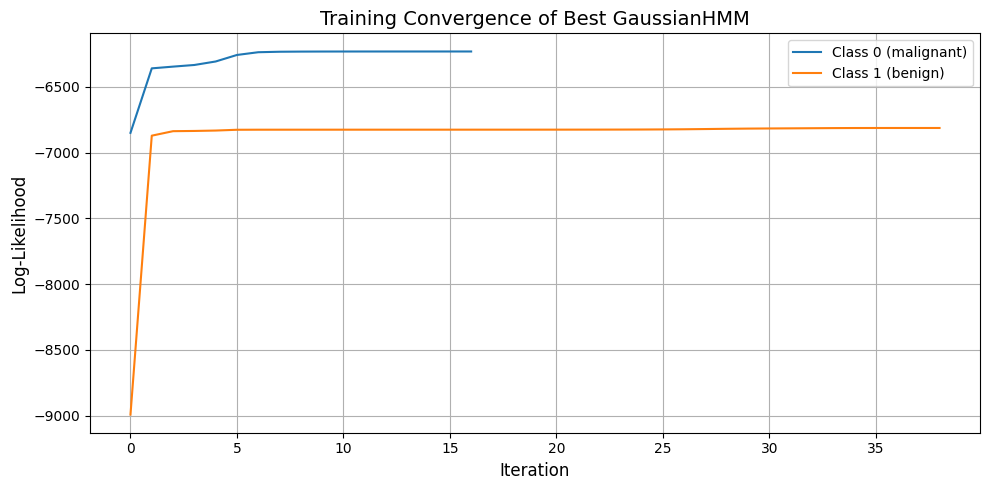

In [ ]:
print("\nRetraining best model to capture convergence history...")
best_n = best_config_bc['n_components']
hmm0 = hmm.GaussianHMM(n_components=best_n, covariance_type="diag", n_iter=100, random_state=42)
hmm1 = hmm.GaussianHMM(n_components=best_n, covariance_type="diag", n_iter=100, random_state=42)
hmm0.fit(best_model_details_bc['X_train_class0'])
hmm1.fit(best_model_details_bc['X_train_class1'])
log_likelihood_history0, log_likelihood_history1 = hmm0.monitor_.history, hmm1.monitor_.history

plt.figure(figsize=(10, 5))
plt.plot(log_likelihood_history0, label=f'Class 0 ({class_names[0]})')
plt.plot(log_likelihood_history1, label=f'Class 1 ({class_names[1]})')
plt.title('Training Convergence of Best GaussianHMM', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**MultinomialHMM on the Wisconsin Breast Cancer dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import load_breast_cancer
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import warnings

warnings.filterwarnings("ignore")

In [ ]:
print(" Loading Wisconsin Breast Cancer Dataset ")
cancer_data = load_breast_cancer()
X_continuous = cancer_data.data
y = cancer_data.target
class_names = cancer_data.target_names

 Loading Wisconsin Breast Cancer Dataset 


In [ ]:
print(" Discretizing Data for MultinomialHMM ")
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
X = discretizer.fit_transform(X_continuous).astype(int)

print("Original first sample (first 5 features):", X_continuous[0, :5])
print("Discretized first sample (first 5 features):", X[0, :5])


 Discretizing Data for MultinomialHMM 
Original first sample (first 5 features): [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01]
Discretized first sample (first 5 features): [5 0 5 3 5]


In [ ]:
split_ratios = [0.2, 0.3, 0.4]
n_components_range = range(2, 9)

results_bc_multi = []
best_overall_accuracy_bc_multi = 0.0
best_config_bc_multi = {}
best_model_details_bc_multi = {}

print("\n Starting Full Search for MultinomialHMM (Splits and Parameters) ")

for split in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    X_train_class0 = X_train[y_train == 0]
    X_train_class1 = X_train[y_train == 1]

    if len(X_train_class0) == 0 or len(X_train_class1) == 0:
        continue

    for n in n_components_range:
        # Use MultinomialHMM
        hmm_class0 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)
        hmm_class1 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)

        hmm_class0.fit(X_train_class0)
        hmm_class1.fit(X_train_class1)

        y_pred, y_scores = [], []
        for sample in X_test:
            sample_reshaped = sample.reshape(1, -1)
            score0, score1 = hmm_class0.score(sample_reshaped), hmm_class1.score(sample_reshaped)
            y_pred.append(1 if score1 > score0 else 0)
            y_scores.append(score1 - score0)

        accuracy = accuracy_score(y_test, y_pred)
        results_bc_multi.append({'split': int((1 - split) * 100), 'n_components': n, 'accuracy': accuracy})

        if accuracy > best_overall_accuracy_bc_multi:
            best_overall_accuracy_bc_multi = accuracy
            best_config_bc_multi = {'split': f"{int((1-split)*100)}/{int(split*100)}", 'n_components': n}
            best_model_details_bc_multi = {'y_test': y_test, 'y_pred': y_pred, 'y_scores': y_scores,
                                'X_train_class0': X_train_class0, 'X_train_class1': X_train_class1}

print(" Search Complete ")

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



 Starting Full Search for MultinomialHMM (Splits and Parameters) 


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/iss

 Search Complete 


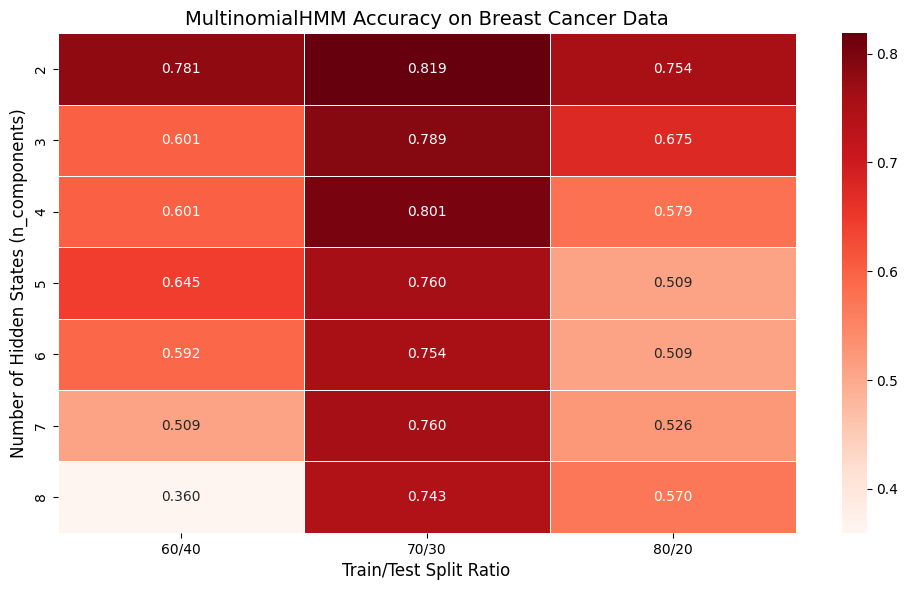

In [ ]:
results_df_bc_multi = pd.DataFrame(results_bc_multi)
pivot_table_bc_multi = results_df_bc_multi.pivot(index='n_components', columns='split', values='accuracy')
pivot_table_bc_multi.columns = [f"{col}/{(100-col)}" for col in pivot_table_bc_multi.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_bc_multi, annot=True, fmt=".3f", cmap="Reds", linewidths=.5)
plt.title('MultinomialHMM Accuracy on Breast Cancer Data', fontsize=14)
plt.xlabel('Train/Test Split Ratio', fontsize=12)
plt.ylabel('Number of Hidden States (n_components)', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Generating visualizations for the BEST MultinomialHMM model:")
print(f"Split: {best_config_bc_multi['split']}, n_components: {best_config_bc_multi['n_components']}, Accuracy: {best_overall_accuracy_bc_multi:.3f}")


Generating visualizations for the BEST MultinomialHMM model:
Split: 70/30, n_components: 2, Accuracy: 0.819


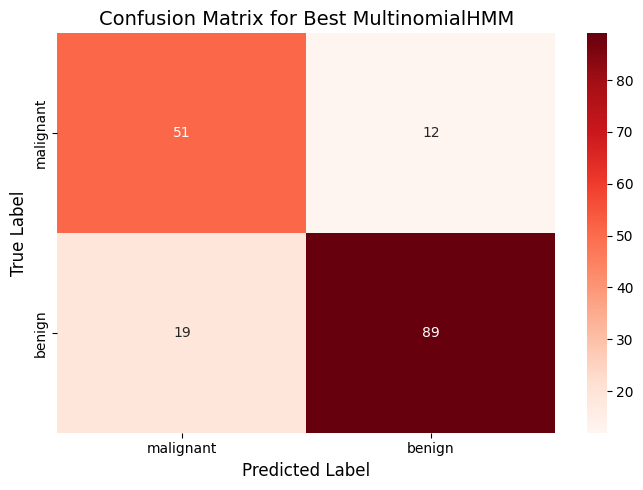

In [ ]:
cm = confusion_matrix(best_model_details_bc_multi['y_test'], best_model_details_bc_multi['y_pred'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best MultinomialHMM', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

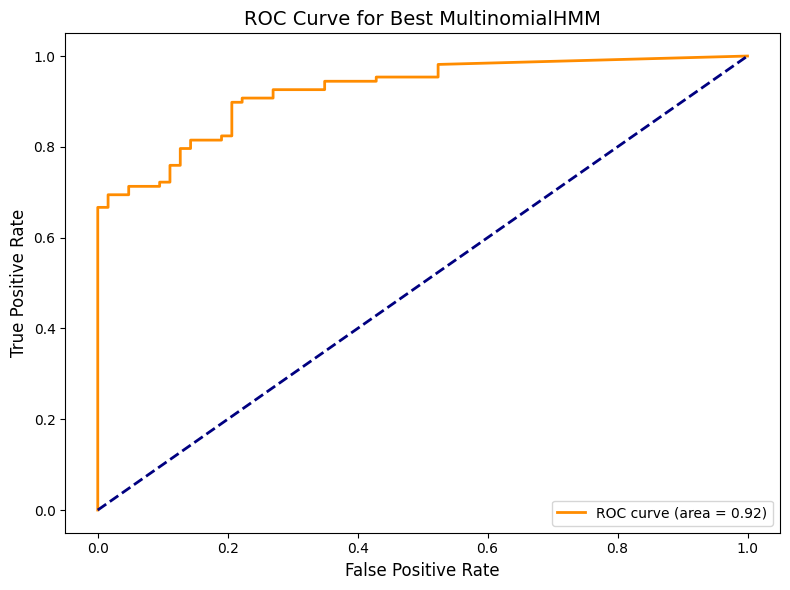

In [ ]:
# Convert scores to a numpy array for easier handling
y_scores_np = np.array(best_model_details_bc_multi['y_scores'])

if not np.all(np.isfinite(y_scores_np)):
    print("Warning: Non-finite scores detected. Cleaning for ROC curve generation...")

    # Find the minimum and maximum of the scores that are not infinity
    min_finite_score = np.min(y_scores_np[np.isfinite(y_scores_np)])
    max_finite_score = np.max(y_scores_np[np.isfinite(y_scores_np)])

    # Replace -inf with the min, inf with the max, and any NaN with 0
    y_scores_np = np.nan_to_num(y_scores_np,
                               nan=0.0,
                               posinf=max_finite_score,
                               neginf=min_finite_score)

# Now, generate the ROC curve using the cleaned scores
fpr, tpr, _ = roc_curve(best_model_details_bc_multi['y_test'], y_scores_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Best MultinomialHMM', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



Retraining best model to capture convergence history...


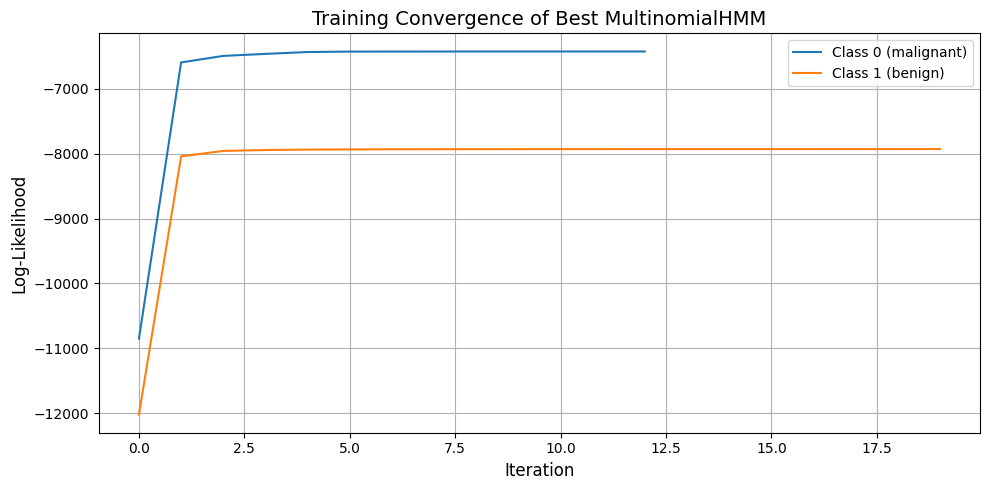

In [ ]:
print("\nRetraining best model to capture convergence history")
best_n = best_config_bc_multi['n_components']
hmm0 = hmm.MultinomialHMM(n_components=best_n, n_iter=100, random_state=42)
hmm1 = hmm.MultinomialHMM(n_components=best_n, n_iter=100, random_state=42)
hmm0.fit(best_model_details_bc_multi['X_train_class0'])
hmm1.fit(best_model_details_bc_multi['X_train_class1'])
log_likelihood_history0, log_likelihood_history1 = hmm0.monitor_.history, hmm1.monitor_.history

plt.figure(figsize=(10, 5))
plt.plot(log_likelihood_history0, label=f'Class 0 ({class_names[0]})')
plt.plot(log_likelihood_history1, label=f'Class 1 ({class_names[1]})')
plt.title('Training Convergence of Best MultinomialHMM', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Final TABLE**

In [ ]:
import logging
from sklearn.metrics import precision_score, recall_score, f1_score

logging.getLogger("hmmlearn").setLevel(logging.ERROR)
# List to store the final results from all experiments
all_results = []
datasets_to_run = ['Ionosphere', 'Breast Cancer']
models_to_run = ['GaussianHMM', 'MultinomialHMM']
for dataset_name in datasets_to_run:
    if dataset_name == 'Ionosphere':
        print(f" Loading Ionosphere Dataset ")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
        data = pd.read_csv(url, header=None)
        X_raw = data.iloc[:, :-1].values
        y_raw = data.iloc[:, -1].values
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y_raw)
    else: # Breast Cancer
        print(f" Loading Wisconsin Breast Cancer Dataset ")
        cancer_data = load_breast_cancer()
        X_raw = cancer_data.data
        y = cancer_data.target

    for model_type in models_to_run:
        print(f"\n>>> Running {model_type} on {dataset_name} <<<")

        if model_type == 'GaussianHMM':
            if dataset_name == 'Breast Cancer':
                scaler = StandardScaler()
                X = scaler.fit_transform(X_raw)
            else:
                X = X_raw # Ionosphere data is already scaled
        else: # MultinomialHMM
            discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
            X = discretizer.fit_transform(X_raw).astype(int)
        split_ratios = [0.2, 0.3, 0.4]
        n_components_range = range(2, 9)
        best_overall_accuracy = 0.0
        best_config = {}
        best_model_details = {}

        for split in split_ratios:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
            X_train_c0, X_train_c1 = X_train[y_train == 0], X_train[y_train == 1]
            if len(X_train_c0) == 0 or len(X_train_c1) == 0: continue

            for n in n_components_range:
                if model_type == 'GaussianHMM':
                    hmm_c0 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
                    hmm_c1 = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, random_state=42)
                else:
                    hmm_c0 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)
                    hmm_c1 = hmm.MultinomialHMM(n_components=n, n_iter=100, random_state=42)

                hmm_c0.fit(X_train_c0)
                hmm_c1.fit(X_train_c1)

                y_pred, y_scores = [], []
                for sample in X_test:
                    sample_r = sample.reshape(1, -1)
                    score0, score1 = hmm_c0.score(sample_r), hmm_c1.score(sample_r)
                    y_pred.append(1 if score1 > score0 else 0)
                    y_scores.append(score1 - score0)

                accuracy = accuracy_score(y_test, y_pred)
                if accuracy > best_overall_accuracy:
                    best_overall_accuracy = accuracy
                    best_config = {'split': f"{int((1-split)*100)}/{int(split*100)}", 'n_components': n}
                    best_model_details = {'y_test': y_test, 'y_pred': y_pred, 'y_scores': y_scores}

        print("Search complete for this configuration.")

        y_true = best_model_details['y_test']
        y_pred = best_model_details['y_pred']

        y_scores_np = np.array(best_model_details['y_scores'])
        if not np.all(np.isfinite(y_scores_np)):
            min_f, max_f = np.min(y_scores_np[np.isfinite(y_scores_np)]), np.max(y_scores_np[np.isfinite(y_scores_np)])
            y_scores_np = np.nan_to_num(y_scores_np, nan=0.0, posinf=max_f, neginf=min_f)

        fpr, tpr, _ = roc_curve(y_true, y_scores_np)
        all_results.append({
            'Dataset': dataset_name,
            'Classifier': model_type,
            'Best Split': best_config['split'],
            'Best n_components': best_config['n_components'],
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0),
            'AUC': auc(fpr, tpr)
        })
summary_df = pd.DataFrame(all_results)

float_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
for col in float_cols:
    summary_df[col] = summary_df[col].map('{:.3f}'.format)

print("           Final Performance Comparison")
display(summary_df)

 Loading Ionosphere Dataset 

>>> Running GaussianHMM on Ionosphere <<<
Search complete for this configuration.

>>> Running MultinomialHMM on Ionosphere <<<
Search complete for this configuration.
 Loading Wisconsin Breast Cancer Dataset 

>>> Running GaussianHMM on Breast Cancer <<<
Search complete for this configuration.

>>> Running MultinomialHMM on Breast Cancer <<<
Search complete for this configuration.
           Final Performance Comparison


,Dataset,Classifier,Best Split,Best n_components,Accuracy,Precision,Recall,F1-Score,AUC
0,Ionosphere,GaussianHMM,60/40,2,0.816,0.830,0.886,0.857,0.795
1,Ionosphere,MultinomialHMM,70/30,5,0.736,0.705,1.000,0.827,0.687
2,Breast Cancer,GaussianHMM,80/20,2,0.947,0.922,1.000,0.959,0.998
3,Breast Cancer,MultinomialHMM,70/30,2,0.819,0.881,0.824,0.852,0.923
